In [2]:
# Cell 1: Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Cell 2: Define BConvLSTM and Hidden Attention Module
import torch
import torch.nn as nn

# ConvLSTM Cell (single direction)
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, padding=1):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = padding
        # Convolution for input-to-state and state-to-state transitions
        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,  # For input, forget, cell, output gates
            kernel_size=kernel_size,
            padding=padding,
            bias=True
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        # Concatenate input and previous hidden state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # [batch, input_dim + hidden_dim, height, width]
        combined_conv = self.conv(combined)
        # Split into gates
        cc_i, cc_f, cc_c, cc_o = torch.split(combined_conv, self.hidden_dim, dim=1)
        # Gate activations
        i = torch.sigmoid(cc_i)  # Input gate
        f = torch.sigmoid(cc_f)  # Forget gate
        o = torch.sigmoid(cc_o)  # Output gate
        c_next = f * c_cur + i * torch.tanh(cc_c)  # Cell state
        h_next = o * torch.tanh(c_next)  # Hidden state
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

# Bidirectional ConvLSTM
class BConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, padding=1):
        super(BConvLSTM, self).__init__()
        self.forward_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size, padding)
        self.backward_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size, padding)
        # Final convolution to combine forward and backward outputs
        self.conv_out = nn.Conv2d(hidden_dim * 2, hidden_dim, kernel_size=1, padding=0)

    def forward(self, x):
        # x: [batch, channels, height, width]
        batch_size, _, height, width = x.size()
        # Initialize hidden states
        h_f, c_f = self.forward_cell.init_hidden(batch_size, (height, width))
        h_b, c_b = self.backward_cell.init_hidden(batch_size, (height, width))
        
        # Forward pass
        h_forward = []
        for t in range(1):  # Single time step (as input is a single feature map)
            h_f, c_f = self.forward_cell(x, cur_state=[h_f, c_f])
            h_forward.append(h_f)
        h_forward = h_forward[0]  # [batch, hidden_dim, height, width]
        
        # Backward pass
        h_backward = []
        for t in range(1):  # Single time step
            h_b, c_b = self.backward_cell(x, cur_state=[h_b, c_b])
            h_backward.append(h_b)
        h_backward = h_backward[0]  # [batch, hidden_dim, height, width]
        
        # Combine forward and backward
        h_combined = torch.cat([h_forward, h_backward], dim=1)  # [batch, hidden_dim*2, height, width]
        output = self.conv_out(h_combined)  # [batch, hidden_dim, height, width]
        return output

# Hidden Attention Module with BConvLSTM
class HiddenAttentionModule(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(HiddenAttentionModule, self).__init__()
        # First Conv Layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second Conv Layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # SE Block
        self.se_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 16, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        # Shortcut Connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        # BConvLSTM
        self.bconvlstm = BConvLSTM(input_dim=out_channels, hidden_dim=out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        # Conv Path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # SE Block
        se = self.se_block(out)
        out = out * se
        # Shortcut
        identity = self.shortcut(identity)
        out += identity
        out = self.relu(out)
        # BConvLSTM
        out = self.bconvlstm(out)
        return out

In [4]:
# Cell 3: Define HA-ResNet Model (with Dropout)
class HA_ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(HA_ResNet, self).__init__()
        self.embedding = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.ham1 = HiddenAttentionModule(64, 64, stride=1)
        self.ham2 = HiddenAttentionModule(64, 128, stride=2)
        self.ham3 = HiddenAttentionModule(128, 256, stride=2)
        self.ham4 = HiddenAttentionModule(256, 512, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)  # Add dropout
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.ham1(x)
        x = self.ham2(x)
        x = self.ham3(x)
        x = self.ham4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [5]:
# Cell 4: Define Custom Dataset (Updated to Preload Images)
class GaitGAFDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        # Preload images into memory
        print("Preloading images into memory...")
        self.images = []
        for img_path in tqdm(image_paths, desc="Loading images"):
            image = Image.open(img_path).convert('RGB')
            self.images.append(image)
        print(f"Loaded {len(self.images)} images into memory.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# Cell 5: Create Dataset Mapping for HA-ResNet Training
import os
import glob

# Define label mapping
label_mapping = {
    "als": 0,
    "control": 1,
    "hunt": 2,
    "park": 3
}

# Base directory
base_dir = os.path.join(os.getcwd(), "gait-in-neurodegenerative-disease-database-1.0.0", "gaf_images_augmented")

# Collect image paths and labels
dataset_mapping = []
groups = ["als", "control", "hunt", "park"]
feature_columns = [
    "L_Stride", "R_Stride", "L_Swing", "R_Swing", "L_Swing%", "R_Swing%", 
    "L_Stance", "R_Stance", "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
]

print("Creating dataset mapping for HA-ResNet training...")
for group in groups:
    label = label_mapping[group]
    for feature in feature_columns:
        feature_dir = os.path.join(base_dir, group, feature)
        if not os.path.exists(feature_dir):
            print(f"Warning: Directory not found: {feature_dir}")
            continue
        
        # Find all .png files in the feature directory
        image_paths = glob.glob(os.path.join(feature_dir, "*.png"))
        for image_path in image_paths:
            dataset_mapping.append((image_path, label))
        
        print(f"Collected {len(image_paths)} images for {group}/{feature}")

# Verify total images
print(f"\nTotal images in dataset: {len(dataset_mapping)} (expected 3072)")
if len(dataset_mapping) != 3072:
    print(f"Warning: Expected 3072 images (64 subjects × 12 features × 4 versions), but found {len(dataset_mapping)}.")

# Example entry
if dataset_mapping:
    print(f"Example entry: {dataset_mapping[0]}")

Creating dataset mapping for HA-ResNet training...
Collected 52 images for als/L_Stride
Collected 52 images for als/R_Stride
Collected 52 images for als/L_Swing
Collected 52 images for als/R_Swing
Collected 52 images for als/L_Swing%
Collected 52 images for als/R_Swing%
Collected 52 images for als/L_Stance
Collected 52 images for als/R_Stance
Collected 52 images for als/L_Stance%
Collected 52 images for als/R_Stance%
Collected 52 images for als/DoubleSupport
Collected 52 images for als/DoubleSupport%
Collected 64 images for control/L_Stride
Collected 64 images for control/R_Stride
Collected 64 images for control/L_Swing
Collected 64 images for control/R_Swing
Collected 64 images for control/L_Swing%
Collected 64 images for control/R_Swing%
Collected 64 images for control/L_Stance
Collected 64 images for control/R_Stance
Collected 64 images for control/L_Stance%
Collected 64 images for control/R_Stance%
Collected 64 images for control/DoubleSupport
Collected 64 images for control/Double

In [ ]:
# Cell 6: Prepare Dataset and DataLoader (Updated with Data Augmentation)
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torchvision import transforms

# Extract image paths and labels from dataset_mapping (from Cell 5)
image_paths = [item[0] for item in dataset_mapping]
labels = [item[1] for item in dataset_mapping]

# Split dataset into train, validation, and test sets (70% train, 10% val, 20% test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.1/0.8, stratify=train_val_labels, random_state=42
)

# Define transforms with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=10),   # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transforms without augmentation for validation and test
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with appropriate transforms
train_dataset = GaitGAFDataset(train_paths, train_labels, transform=train_transform)
val_dataset = GaitGAFDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = GaitGAFDataset(test_paths, test_labels, transform=val_test_transform)

# Compute class weights for WeightedRandomSampler (to handle class imbalance)
label_counts = Counter(train_labels)
num_samples = len(train_labels)
class_weights = {i: num_samples / (len(label_counts) * count) for i, count in label_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders with optimized settings
batch_size = 32 
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

# Print dataset sizes and class distributions
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Training class distribution: {Counter(train_labels)}")
print(f"Validation class distribution: {Counter(val_labels)}")
print(f"Test class distribution: {Counter(test_labels)}")

Preloading images into memory...


Loading images:   0%|          | 0/2149 [00:00<?, ?it/s]

Loaded 2149 images into memory.
Preloading images into memory...


Loading images:   0%|          | 0/308 [00:00<?, ?it/s]

Loaded 308 images into memory.
Preloading images into memory...


Loading images:   0%|          | 0/615 [00:00<?, ?it/s]

Loaded 615 images into memory.
Training dataset size: 2149
Validation dataset size: 308
Test dataset size: 615
Training class distribution: Counter({2: 672, 1: 537, 3: 504, 0: 436})
Validation class distribution: Counter({2: 96, 1: 77, 3: 72, 0: 63})
Test class distribution: Counter({2: 192, 1: 154, 3: 144, 0: 125})


In [ ]:
# Cell 7: Training and Evaluation Functions (Updated with Scheduler and Early Stopping)
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    scaler = GradScaler()  # For mixed precision training
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    best_val_f1 = 0.0
    best_model_state = None
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_true = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():  # Mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.tolist())
            train_true.extend(labels.tolist())
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = accuracy_score(train_true, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_true, train_preds, average='weighted', zero_division=0
        )

        # Validation
        model.eval()
        val_preds = []
        val_true = []
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.tolist())
                val_true.extend(labels.tolist())
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(val_true, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_true, val_preds, average='weighted', zero_division=0
        )

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train - Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
        print(f"Unique predicted classes (val): {np.unique(val_preds)}")

        # Step the scheduler based on validation F1-score
        scheduler.step(val_f1)

        # Early stopping based on validation F1-score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            torch.save(best_model_state, 'best_ha_resnet.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return best_model_state

def evaluate_model(model, test_loader, device):
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.tolist())
            true.extend(labels.tolist())

    accuracy = accuracy_score(true, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true, preds, average='weighted', zero_division=0
    )
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Unique predicted classes (test): {np.unique(preds)}")

    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ALS', 'Control', 'Huntington', 'Parkinson'],
                yticklabels=['ALS', 'Control', 'Huntington', 'Parkinson'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Epoch 1/100
Train - Loss: 1.2153, Accuracy: 0.4295, F1: 0.4240
Val   - Loss: 1.4855, Accuracy: 0.3182, F1: 0.2263
Unique predicted classes (val): [0 1 3]
Epoch 2/100
Train - Loss: 0.8817, Accuracy: 0.6622, F1: 0.6608
Val   - Loss: 1.2195, Accuracy: 0.5227, F1: 0.4931
Unique predicted classes (val): [0 1 2 3]
Epoch 3/100
Train - Loss: 0.5709, Accuracy: 0.7887, F1: 0.7866
Val   - Loss: 0.6421, Accuracy: 0.7370, F1: 0.7380
Unique predicted classes (val): [0 1 2 3]
Epoch 4/100
Train - Loss: 0.4060, Accuracy: 0.8520, F1: 0.8512
Val   - Loss: 0.7902, Accuracy: 0.7370, F1: 0.7372
Unique predicted classes (val): [0 1 2 3]
Epoch 5/100
Train - Loss: 0.2753, Accuracy: 0.9037, F1: 0.9034
Val   - Loss: 0.6982, Accuracy: 0.7695, F1: 0.7713
Unique predicted classes (val): [0 1 2 3]
Epoch 6/100
Train - Loss: 0.2541, Accuracy: 0.9060, F1: 0.9057
Val   - Loss: 0.7017, Accuracy: 0.8214, F1: 0.8205
Unique predicted classes (val): [0 1 2 3]
Epoch 7/100
Train - Loss: 0.1557, Accuracy: 0.9437, F1: 0.9436
Val

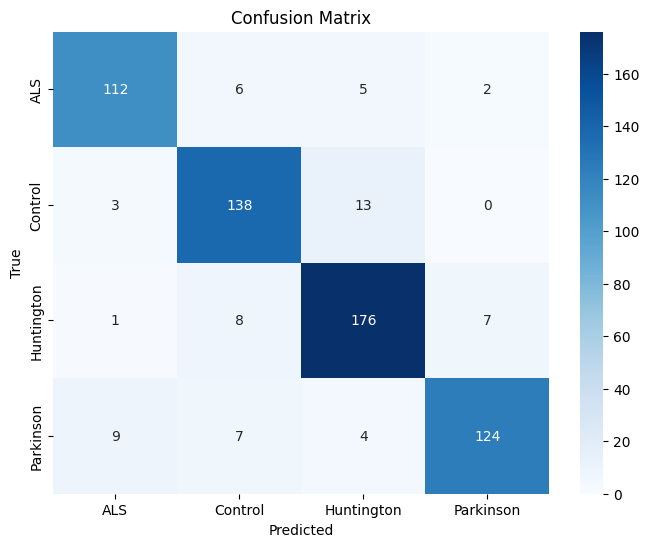

In [ ]:
# Cell 8: Main Execution (Updated with Recalculated Class Weights, Scheduler, and Early Stopping)
# Initialize model
model = HA_ResNet(num_classes=4).to(device)

# Class weights for imbalanced dataset (based on training set distribution)
class_weights = torch.tensor([1.231, 1.000, 0.799, 1.066], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
learning_rate = 0.001  # As per paper
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Training parameters
num_epochs = 50  # Reduced with early stopping
patience = 5  # Early stopping patience

# Train model and get the best model state
best_model_state = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience)

# Load the best model state and evaluate
model.load_state_dict(best_model_state)
evaluate_model(model, test_loader, device)